In [1]:
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Reshape, UpSampling2D, BatchNormalization, AveragePooling2D, Activation, Lambda
from keras.models import Model, Sequential
from keras import backend as K

height = 360
width =  640

Using TensorFlow backend.


In [4]:
encoder_input =  Input(shape=(height,width,3))

# Encoder Layers
#autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
encoder = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)
encoder = AveragePooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
encoder = AveragePooling2D((2, 2), padding='same')(encoder)
encoder =  Flatten(name='flatten_1')(encoder)
encoder_model = Model(encoder_input,encoder)
encoder_model.summary()
#encoder_model.load_weights("6-encoder.h5")
#

# Decoder Layers
decoder_input = Input(shape=( 115200,))
#decoder = Dense(38400,activation="relu",name='decoder_input')(decoder_input)
decoder = Reshape(( 90, 160, 8))(decoder_input)
decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
decoder =  UpSampling2D((2, 2),interpolation='bilinear')(decoder)
decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2),interpolation='bilinear')(decoder)
decoder = Conv2D(16, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2),interpolation='bilinear')(decoder)
decoder = Conv2D(8, (3, 3), padding='same',activation='relu')(decoder)
decoder = Conv2D(3, (3, 3), padding='same',activation='relu')(decoder)


decoder_model = Model(decoder_input,decoder)
decoder_model.summary()
#decoder_model.load_weights("6-decoder.h5")

autoencoder = Model(encoder_input,decoder_model(encoder))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 360, 640, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 360, 640, 16)      448       
_________________________________________________________________
average_pooling2d_5 (Average (None, 180, 320, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 180, 320, 8)       1160      
_________________________________________________________________
average_pooling2d_6 (Average (None, 90, 160, 8)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0         
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________
________

In [5]:
import cv2, os
import numpy as np

dir_ = "./crowdsource_images-00000-of-00010/"
X = list()
Y = list()
files = os.listdir(dir_)

def getImage(file):
    #‪C:\Users\mayan\Downloads\2-dog.jpg
    frame = cv2.imread(file,1)
    return [np.array([cv2.resize(frame,(width,height))]),np.array([cv2.resize(frame,(width*2,height * 2))])]

def getData(batch_size=128):
    while True:
        for i , file in enumerate(files):
            frame = cv2.imread(dir_ + file,1)
            try:
                Y.append(cv2.resize(frame,(width*2,height*2)))
                X.append(cv2.resize(frame,(width,height)))
                if (i + 1) % batch_size == 0:
                        yield (np.array(X),np.array(Y))
                        X.clear()
                        Y.clear()
            except Exception:
                pass

               
            """
            capture = cv2.VideoCapture("C:/Users/mayan/Desktop/VID_20190731_103410.mp4")
            while capture.isOpened() :
                et,frame = capture.read()
                if et:
                    Y.append(cv2.resize(frame,(480,640)))
                    X.append(cv2.resize(frame,(240,320)))
                else:
                    break
            capture.release()

            import os
            video_files= os.listdir('./Videos/')[:2]

            for file in video_files:

                capture = cv2.VideoCapture("./Videos/" + file)
                while capture.isOpened() :
                    et,frame = capture.read()
                    if et:
                        Y.append(cv2.resize(frame,(480,640)))
                        X.append(cv2.resize(frame,(240,320)))
                    else:
                        break
                capture.release()
            """

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
from keras.optimizers import Adam, Adadelta

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,horizontal_flip=True,vertical_flip=True)
# fit parameters from data
#datagen.fit(frames)
# configure batch size and retrieve one batch of images

#autoencoder.compile(optimizer='adam', loss=vae_loss)
#for X_, Y_ in datagen.flow(X,Y, batch_size=256):
#autoencoder.fit_generator(getData(8),epochs=10,samples_per_epoch=50)
autoencoder.compile(optimizer='adam', loss='mean_absolute_error',metrics=['acc'])

for X_, Y_ in getData(256):
    #for X_D,Y_D in datagen.flow(X_,Y_,batch_size=128): 
    autoencoder.fit(X_, Y_,
                epochs=10,
                batch_size=8,validation_split=0.2)
    clear_output()

    json= decoder_model.to_json()
    with open("8-decoder.json", "w") as json_file:
        json_file.write(json)

    decoder_model.save_weights("8-decoder.h5")

    json= encoder_model.to_json()
    with open("8-encoder.json", "w") as json_file:
        json_file.write(json)
    encoder_model.save_weights("8-encoder.h5")

    print("Saved model to disk")


Saved model to disk
Train on 204 samples, validate on 52 samples
Epoch 1/10
204/204 [==============================] - 14s 68ms/step - loss: 5.8212 - acc: 0.8424 - val_loss: 5.8594 - val_acc: 0.8687
Epoch 2/10
204/204 [==============================] - 14s 67ms/step - loss: 6.0142 - acc: 0.8559 - val_loss: 5.8995 - val_acc: 0.8072
Epoch 3/10
204/204 [==============================] - 14s 68ms/step - loss: 5.7755 - acc: 0.8513 - val_loss: 5.8431 - val_acc: 0.8446
Epoch 4/10
204/204 [==============================] - 14s 68ms/step - loss: 5.6909 - acc: 0.8639 - val_loss: 5.4669 - val_acc: 0.8810


In [ ]:
##Save Model
json= decoder_model.to_json()
with open("decoder.json", "w") as json_file:
    json_file.write(json)

decoder_model.save_weights("decoder.h5")

json= encoder_model.to_json()
with open("encoder.json", "w") as json_file:
    json_file.write(json)
encoder_model.save_weights("encoder.h5")

print("Saved model to disk")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

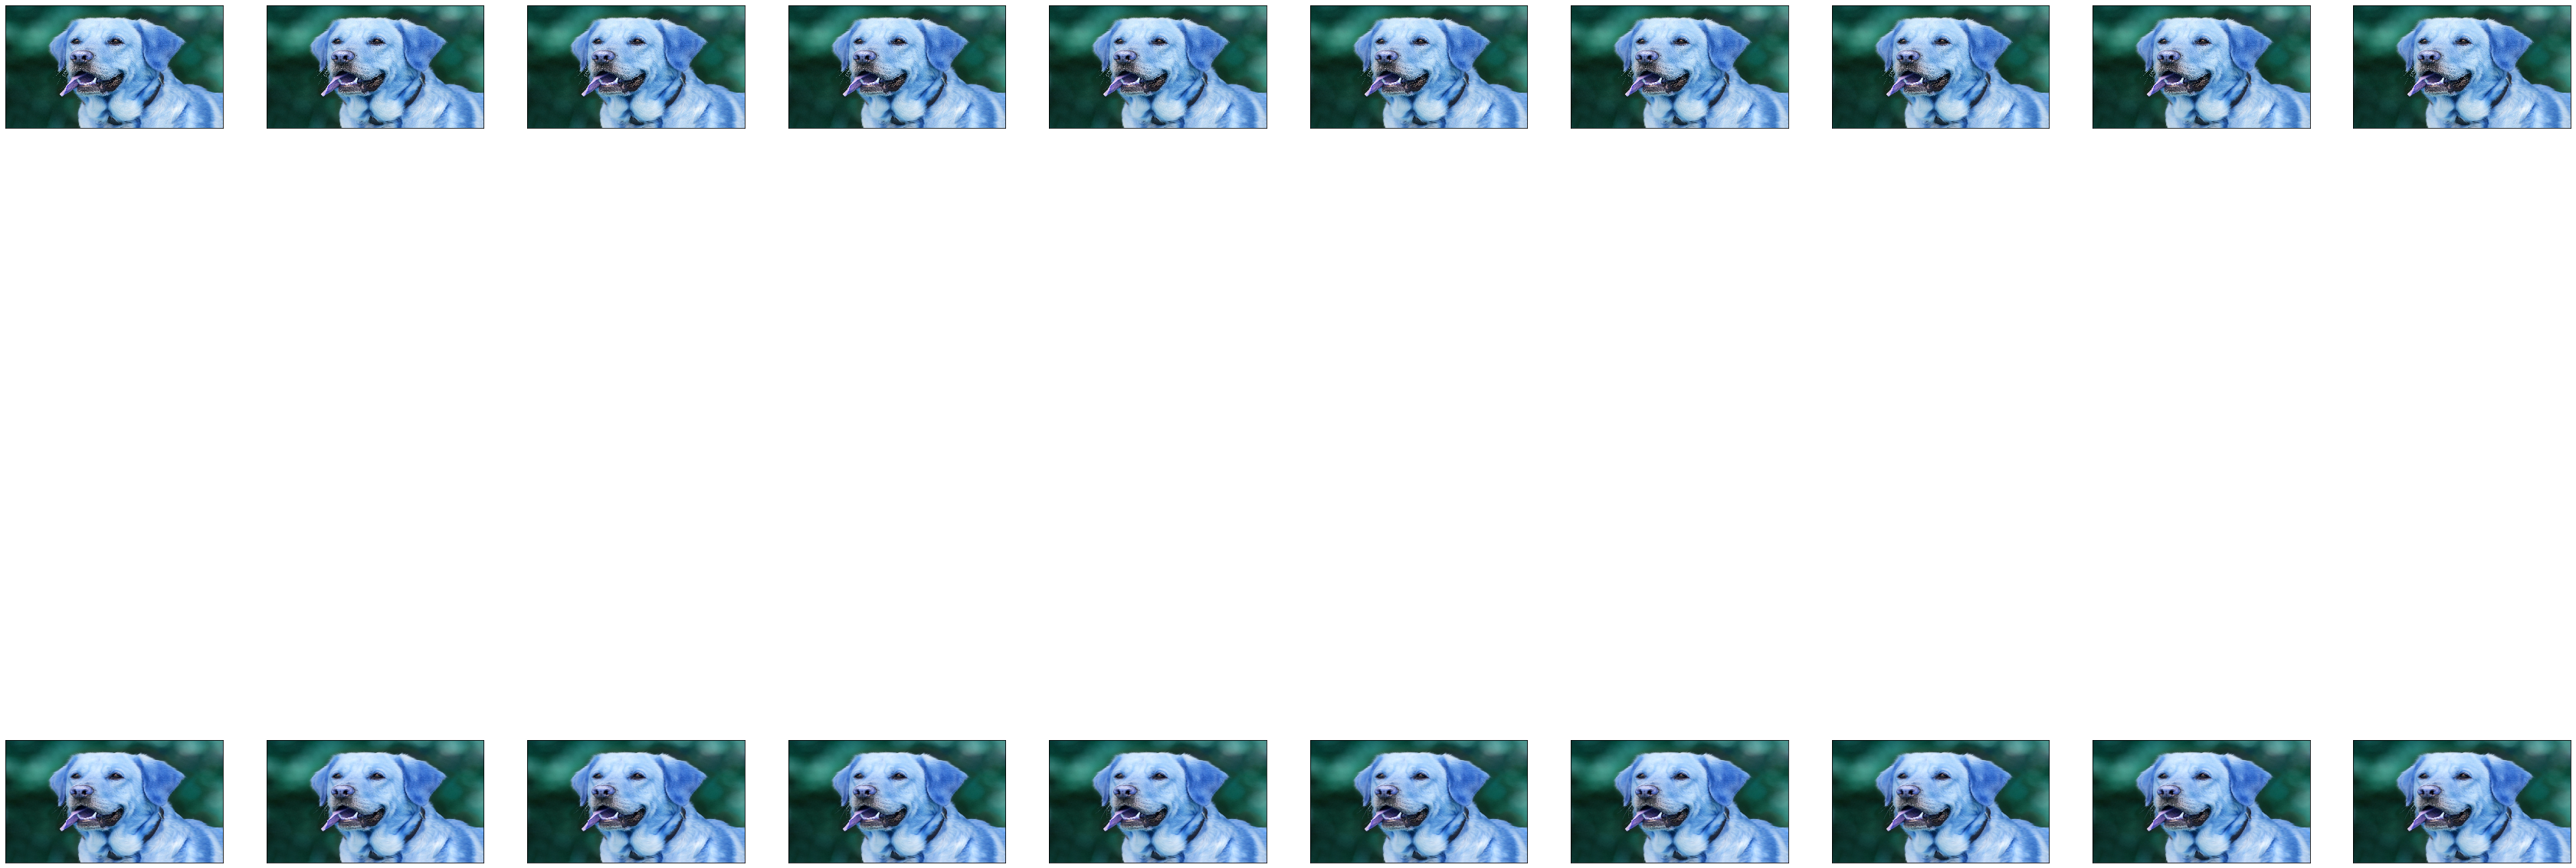

In [10]:
import matplotlib.pyplot as plt
import imutils, time

%matplotlib inline

num_images = 10
np.random.seed(42)

#x_test,y_test = next(getData(16))
x_test,y_test = getImage('C:/Users/mayan/Downloads/2-dog.jpg')

random_test_images = np.random.randint(y_test.shape[0], size=min(num_images,y_test.size))

encoded_imgs = encoder_model.predict(x_test)
decoded_imgs = decoder_model.predict(encoded_imgs)


plt.figure(figsize=(60, 50))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(y_test[image_idx])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cv2.imwrite("./real/%s.jpg" %time.time(),y_test[image_idx])
    '''
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(32, 16))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    '''
    # plot reconstructed image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    name = time.time()
    cv2.imwrite("./restructured/%s.jpg" %name,decoded_imgs[image_idx] )
    cv2.imwrite("./restructured/original-%s.jpg" %name,y_test[image_idx] )
    plt.imshow(decoded_imgs[image_idx]/255)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()